# Tarea 6
## Francisco Javier Peralta Ramírez

Para el problema IMDB, construya una red de dos canales, una Recurrente y otra Densa. La recurrente procesa datos previamente "incrustados" y la densa considera un vectopr de tamaño a lo mas 10,000 con estras binarias que indicas si la palabra con dicho índice es contenida en la reseña (red de dos entradas). La red tienen un sola salida que significa la interpretación del sentir (positivo o negativo). Usar API de Kreras

In [1]:
import time
import keras

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Embedding, CuDNNLSTM, concatenate, Dropout
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


Podemos generar una red neuronal reccurente y ver como se comporta con los datos de IMDB

In [2]:
max_features = 10000  # tamaño del diccionario de palabras comunes
                      # (número de palabras a utilizar)
maxlen = 500          # longitud máxima de cada secuencia 
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

In [3]:
#agregamos un padding a nuestros datos, esto nos sirve para nuestra red recurrente
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

Para la red neuronal densa necesitamos crear un vector de tamaño `max_features` donde en cada indice tendremos un `1` si la palabra está en la reseña.

In [4]:
def __to_dense_vector(data, max_features):
    _dense_vector = np.zeros((data.shape[0], max_features))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            _dense_vector[i, data[i,j]] = 1
    return _dense_vector

In [5]:
%%time
dense_train = __to_dense_vector(input_train, max_features)
dense_test  = __to_dense_vector(input_test , max_features)

CPU times: user 6.13 s, sys: 598 ms, total: 6.73 s
Wall time: 6.73 s


Hacemos pruebas individuales con una red densa. La red es bastante simple y consiste en dos capas escondidas con treinta y dos neuronas cada una. También agregamos una capa de *Dropout* con la finalidad de prevenir overfitting.

Nota: Usamos la notación *funcional* ya que esta nos da más libertad y nos permite crear redes más complejas como la de canal doble.

In [6]:
inputs = Input(shape=(max_features, ), name='Input')
x = Dropout(.5)(inputs)
x = Dense(32, name='D1')(x)
x = Dense(32, name='D2')(x)
preds = Dense(1, activation='sigmoid', name='pred')(x)
dense_model = Model(inputs=inputs, outputs=preds)

plot_model(dense_model, to_file='dense_model.png', show_shapes=True, show_layer_names=True)
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 10000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
D1 (Dense)                   (None, 32)                320032    
_________________________________________________________________
D2 (Dense)                   (None, 32)                1056      
_________________________________________________________________
pred (Dense)                 (None, 1)                 33        
Total params: 321,121
Trainable params: 321,121
Non-trainable params: 0
_________________________________________________________________


![alt text](./dense_model.png "Logo Title Text 1")

In [7]:
dense_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [8]:
%%time
history_dense = dense_model.fit(dense_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0)

CPU times: user 18.4 s, sys: 1.29 s, total: 19.6 s
Wall time: 14.2 s


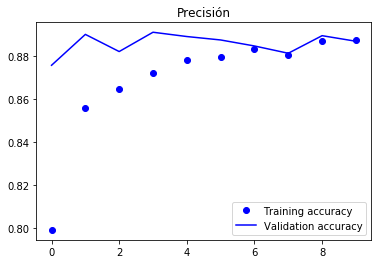

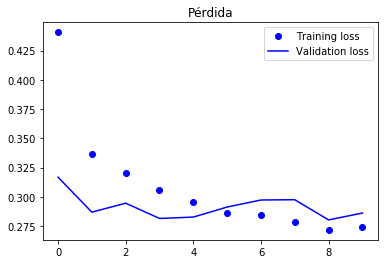

In [9]:
acc = history_dense.history['acc']
val_acc = history_dense.history['val_acc']
loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Precisión')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Pérdida')
plt.legend()

plt.show()

In [10]:
scores = dense_model.evaluate(dense_test, y_test)
print("\n%s: %.2f%%" % (dense_model.metrics_names[1], scores[1]*100))

25000/25000 [==============================] - 2s 78us/step

acc: 87.85%


Podemos observar que la red densa tiene un desempeño aceptable con un accurracy del ~87% sobre datos nuevos.

Nota, la capa embedding nos ayuda a pasar nuestros datos que se encuentran en un vector de tamaño 500 a una matriz de `500 * M`, donde nosotros decidimos el valor de M. Esto es para que cada palabra tenga su representación vectorial.

In [11]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=32))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_train)
output_array.shape # 25000 reviews, 500 palabras(features), encoding de 32 valores

(25000, 500, 32)

In [12]:
inputs = Input(shape=(500,))
x = Embedding(input_dim=max_features, output_dim=32, name="Embedding")(inputs)
x = Dropout(.5, name="Dropout")(x)
x = CuDNNLSTM(32, name="LSTM1", return_sequences=True)(x)
x = CuDNNLSTM(32, name="LSTM2")(x)
preds = Dense(1, activation='sigmoid', name="D_out")(x)
model = Model(inputs=inputs, outputs=preds)

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
Dropout (Dropout)            (None, 500, 32)           0         
_________________________________________________________________
LSTM1 (CuDNNLSTM)            (None, 500, 32)           8448      
_________________________________________________________________
LSTM2 (CuDNNLSTM)            (None, 32)                8448      
_________________________________________________________________
D_out (Dense)                (None, 1)                 33        
Total params: 336,929
Trainable params: 336,929
Non-trainable params: 0
_________________________________________________________________


![alt text](./model.png "Logo Title Text 1")

In [13]:
%%time
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0)

CPU times: user 1min 7s, sys: 2.1 s, total: 1min 9s
Wall time: 1min 3s


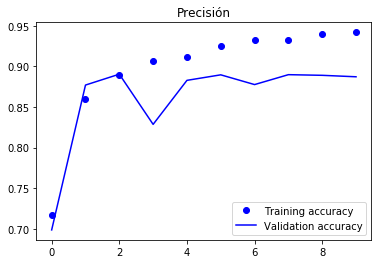

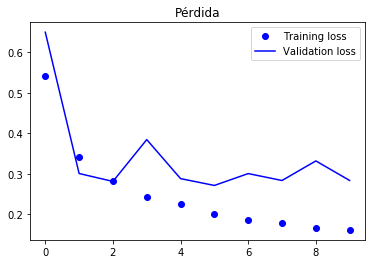

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Precisión')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Pérdida')
plt.legend()

plt.show()

In [15]:
%%time
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0)
scores = model.evaluate(input_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

25000/25000 [==============================] - 15s 589us/step

acc: 86.60%
CPU times: user 50.2 s, sys: 1.42 s, total: 51.6 s
Wall time: 46.6 s


Curiosamente observamos que ambas redes tienen un accuracy similar, con la red densa siendo ligeramente mejor.

Ahora creamos una red de dos canales. Dado el pre-procesado requerido para la red densa, tendremos que tener dos capas de input

In [16]:
#parte densa
d_inputs = Input(shape=(max_features, ), name='Input_Dense')
d = Dropout(.5, name="Dropout_Dense")(d_inputs)
d = Dense(32, name='D1')(d)
d = Dense(32, name='D2')(d)

#parte recurrente
r_inputs = Input(shape=(500,), name='Input_Recurrent')
r = Embedding(input_dim=max_features, output_dim=32, name="Embedding")(r_inputs)
r = Dropout(.5, name="Dropout_Reccurrent")(r)
r = CuDNNLSTM(32, name="LSTM1", return_sequences=True)(r)
r = CuDNNLSTM(32, name="LSTM2")(r)

merge = concatenate([d, r], axis=1)
# merge = Dropout(.5)(merge)
preds = Dense(1, activation='sigmoid', name='pred')(merge)
dual_model = Model(inputs=[d_inputs, r_inputs], outputs=preds)

plot_model(dual_model, to_file='dual_model.png', show_shapes=True, show_layer_names=True)

dual_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Recurrent (InputLayer)    (None, 500)          0                                            
__________________________________________________________________________________________________
Input_Dense (InputLayer)        (None, 10000)        0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 500, 32)      320000      Input_Recurrent[0][0]            
__________________________________________________________________________________________________
Dropout_Dense (Dropout)         (None, 10000)        0           Input_Dense[0][0]                
__________________________________________________________________________________________________
Dropout_Re

![alt text](./dual_model.png "Logo Title Text 1")

In [17]:
%%time
dual_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
d_history = dual_model.fit([dense_train, input_train], y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0)

CPU times: user 1min 19s, sys: 2.19 s, total: 1min 21s
Wall time: 1min 13s


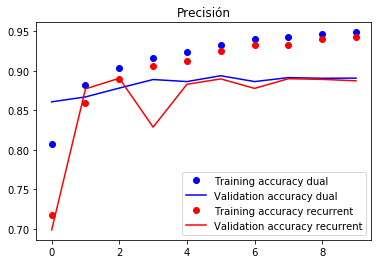

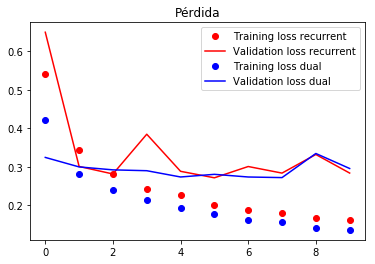

In [18]:
acc_d = d_history.history['acc']
val_acc_d = d_history.history['val_acc']
loss_d = d_history.history['loss']
val_loss_d = d_history.history['val_loss']

epochs_d = range(len(acc_d))

plt.plot(epochs_d, acc_d, 'bo', label='Training accuracy dual')
plt.plot(epochs_d, val_acc_d, 'b', label='Validation accuracy dual')

plt.plot(epochs, acc, 'ro', label='Training accuracy recurrent')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy recurrent')

plt.title('Precisión')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'ro', label='Training loss recurrent')
plt.plot(epochs, val_loss, 'r', label='Validation loss recurrent')

plt.plot(epochs_d, loss_d, 'bo', label='Training loss dual')
plt.plot(epochs_d, val_loss_d, 'b', label='Validation loss dual')

plt.title('Pérdida')
plt.legend()

plt.show()

Notamos que despues de tres epocas nuestra perdida de validación empieza a incrementar, por lo cual podemos dejar el número de epocas en 3.

In [19]:
%%time
dual_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
d_history = dual_model.fit([dense_train, input_train], y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0)

CPU times: user 40.9 s, sys: 1.31 s, total: 42.2 s
Wall time: 37.9 s


In [20]:
scores = dual_model.evaluate([dense_test, input_test], y_test)
print("\n%s: %.2f%%" % (dual_model.metrics_names[1], scores[1]*100))

25000/25000 [==============================] - 16s 640us/step

acc: 87.28%


Podemos ver que el accuracy mejora ligeramente a comparación de la red recurrente, pero es practicamente el mismo que la red densa.